# Setup

In [1]:
import helpers.preprocessing as dataprocess
from helpers.utilities import Progress

from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from spacy.lang.fr.examples import sentences 
import fr_core_news_sm
nlp = spacy.load('fr_core_news_sm')

from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meghanharrington/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/meghanharrington/ml-project-2-turboml/helpers/utilities.py:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.current < self.steps, "Did you forget to reset the progress bar?")


In [3]:
data = dataprocess.cleanup(dataprocess.load("data/impresso3.csv"))
article_count = len(data)
progress = Progress(article_count)
print(article_count, "articles")
data.sample(4)

/Users/meghanharrington/opt/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


4352 articles


,uid,type,language,title,size,country,newspaper,issue,pages,nb_pages,...,year,is_on_front,date,persons_mentioned,locations_mentioned,content,access_right,content_provider,is_content_available,"[total:7120,available:7200]"
119,IMP-1984-01-23-a-i0052,NaN,fr,Poids lourds ? Pas tant que ça...,903,CH,IMP,IMP-1984-01-23-a,6,1,...,1984,False,1984-01-23 00:00:00+00:00,NaN,Genève|Genève|Suisse|Suisse,Poids lourds ? Pas tant que ça... 8 e Salon de...,OpenPrivate,SNL,y,NaN
315,JDG-1991-01-21-a-i0072,NaN,fr,Appels pressants à la paix,317,CH,JDG,JDG-1991-01-21-a,11,1,...,1991,False,1991-01-21 00:00:00+00:00,Pierre-Alain Tschudi|Saddam Hussein|Saddam Hus...,Genève|Genève|Tel-Aviv|Genève,Appels pressants à la paix Une fois que les ar...,OpenPrivate,SNL,y,NaN
3849,LLE-2012-03-03-a-i0207,NaN,fr,LA LIBERTE,210,CH,LLE,LLE-2012-03-03-a,36,1,...,2012,False,2012-03-03 00:00:00+00:00,STEPHANIE DE MONACO|prince Rainier|Stéphanie d...,NaN,LA LIBERTE un m nm IIIIII m IIIIII un m Mil II...,OpenPrivate,SNL,y,NaN
1675,IMP-2000-04-26-a-i0258,NaN,fr,Jeux vidéo Ça roule,304,CH,IMP,IMP-2000-04-26-a,32,1,...,2000,False,2000-04-26 00:00:00+00:00,Tony Hawk|Tony Hawk|Tony Hawk|Tony Hawk|Pascal...,Switzerland|La Chaux-de-Fonds,Jeux vidéo Ça roule Avec plus d'un million de ...,OpenPrivate,SNL,y,NaN


# First approach
We will try to categorize each artice as being either positive or negative and see how this evolves through years.

In [3]:
# Tokenize each article in corpus
progress.reset()

docs = []
for i in range(article_count):
    docs.append(nlp(data.content.iloc[i]))
    progress.bump()

Progress: [####################] 100.0%


In [8]:
progress.reset()
# Assign a score to every sentence

analyzer = SentimentIntensityAnalyzer()
progress.reset()

sentiments = []
for doc in docs:
    current = []
    for sentence in doc.sents:
        current.append(analyzer.polarity_scores(sentence.text)['compound'])
    sentiments.append(current)
    progress.bump()

assert(len(sentiments) == len(docs))
assert(len(sentiments[0]) == len(list(docs[0].sents)))

Progress: [####################] 100.0%


In [9]:
# Assign an overall classification (positive/negative/neutral)
# to the document, depending on the average polarity of all sentence.
# Idea from https://github.com/cjhutto/vaderSentiment#resources-and-dataset-descriptions; section: About the Scoring
# Return: the sentiment, in one-hot encoding
def classify_doc(scores):
    avg = np.average(scores)
    if(avg >= 0.5):
        return [1, 0, 0]
    elif(avg <= -0.5):
        return [0, 1, 0]
    else:
        return [0, 0, 1]

docs_class = [classify_doc(doc) for doc in sentiments]

In [11]:
assert(len(docs_class) == article_count)

# Create a frame for dates/sentiment
df_class = pd.DataFrame(docs_class, columns=["positive", "negative", "neutral"])

df = pd.concat([data, df_class], axis=1)[["year", "positive", "negative", "neutral"]]
df.sample(2)

,year,positive,negative,neutral
3796,2008.0,0.0,0.0,1.0
4887,2005.0,NaN,NaN,NaN


In [12]:
# Group by years
grouped = df.groupby(["year"]).sum().reset_index(drop=False)
yearly_count = df.groupby(["year"])["year"].count().reset_index(drop=True)

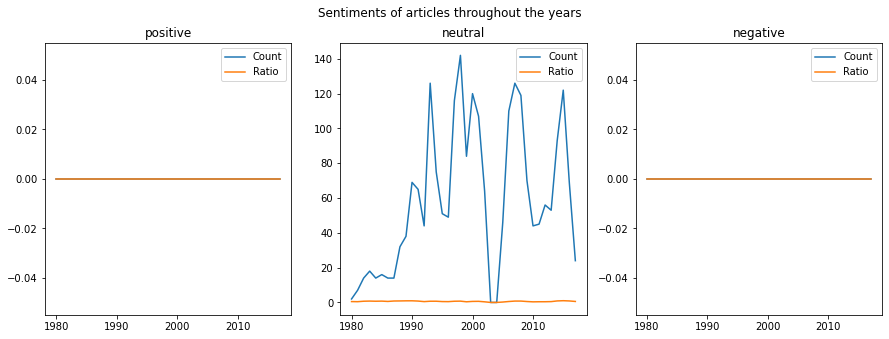

In [32]:
def plot(df, fig, i, y):
    ax = fig.add_subplot(1, 3, i)
    ax.plot(df["year"], df[y], label="Count")
    ax.plot(df["year"], df[y].divide(yearly_count), label="Ratio")
    ax.set_title(y)
    ax.legend()
    i = i + 1

fig = plt.figure(figsize = (15,5))

plot(grouped, fig, 1, "positive")
plot(grouped, fig, 2, "neutral")
plot(grouped, fig, 3, "negative")

fig.suptitle("Sentiments of articles throughout the years")
plt.show()

As you can see, trying to assign a sentiment to articles this way doesn't yield anything meaninful.
The reason can be seen by plotting the sentiment of all sentences separately.

In [20]:
sentences_score = []
for document in sentiments:
    for sentence in document:
        sentences_score.append(sentence)

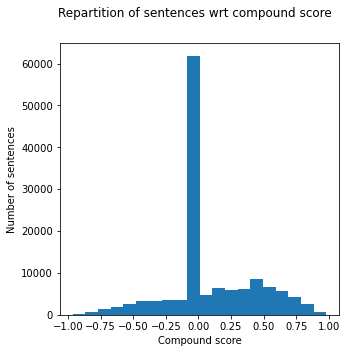

In [22]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1, 1, 1)
ax.hist(sentences_score, bins = 20)
ax.set_xlabel("Compound score")
ax.set_ylabel("Number of sentences")
fig.suptitle("Repartition of sentences wrt compound score")
plt.show()

We see that all that the "neutral" sentences (scores between -0.5 and 0.5) are way too common. 
This means that most articles will end up with an average in this neutral zone as well.

In particular, the [-0.25, 0.00] class seems to be overrepresented; in fact, further analysis show that it is the zero score which is overrepresented.

56201 sentences with a score of zero (42.15%)


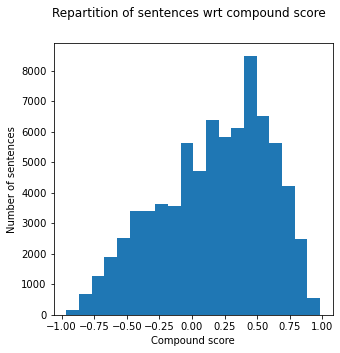

In [35]:
zero_score_count = np.count_nonzero( np.abs( np.array(sentences_score) ) < 1e-6 )
score_count = len(sentences_score)
print("{} sentences with a score of zero ({:.2f}%)".format(zero_score_count, zero_score_count/score_count * 100))

nz_sentences_score = np.array(sentences_score)[np.abs(sentences_score) > 1e-6]

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1, 1, 1)
ax.hist(nz_sentences_score, bins = 20)
ax.set_xlabel("Compound score")
ax.set_ylabel("Number of sentences")
fig.suptitle("Repartition of sentences wrt compound score")
plt.show()

In [39]:
def classify_doc_filtered(scores):
    scores = np.array(scores)
    scores = scores[np.abs(scores) > 1e-6]
    if len(scores) == 0:
        scores = [0]
    avg = np.average(scores)
    if(avg >= 0.5):
        return [1, 0, 0]
    elif(avg <= -0.5):
        return [0, 1, 0]
    else:
        return [0, 0, 1]

docs_filtered_class = [classify_doc_filtered(doc) for doc in sentiments]

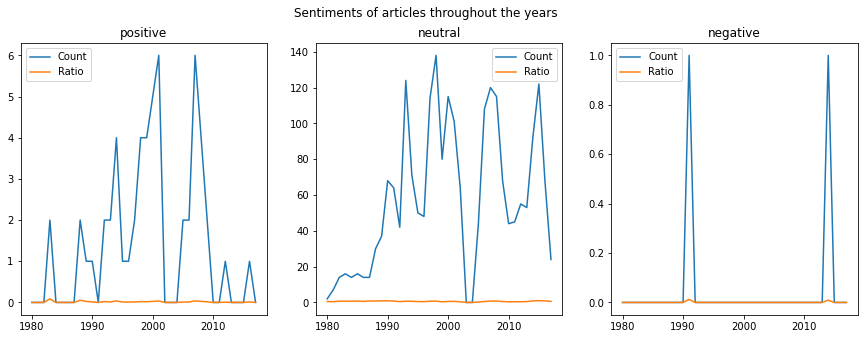

In [40]:
assert(len(docs_filtered_class) == article_count)

# Create a frame for dates/sentiment
df_fclass = pd.DataFrame(docs_filtered_class, columns=["positive", "negative", "neutral"])
dff = pd.concat([data, df_fclass], axis=1)[["year", "positive", "negative", "neutral"]]

# Group by years
groupedf = dff.groupby(["year"]).sum().reset_index(drop=False)

# Plot
fig = plt.figure(figsize = (15,5))

plot(groupedf, fig, 1, "positive")
plot(groupedf, fig, 2, "neutral")
plot(groupedf, fig, 3, "negative")

fig.suptitle("Sentiments of articles throughout the years")
plt.show()